## Imports packages 

In [1]:
import time

# Start counting notebook running time
time_start = time.time()

import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression
from sklearn.ensemble import StackingRegressor

# Mute warnings
import warnings
warnings.filterwarnings('ignore')

## Import train and test data

In [2]:
# Train data
train = pd.read_csv("train.csv", index_col="Id")
X_train = train.copy()
print('train data size: ', X_train.shape)
y_train = X_train.pop("SalePrice")

# Test data
test = pd.read_csv("test.csv", index_col="Id")
X_test = test.copy()
print('test data size: ', X_test.shape)

train data size:  (1460, 80)
test data size:  (1459, 79)


## Define all data preprocessing steps

In [3]:
# Renaming some features
# Feature names beginning with numbers are awkward to work with, so we rename them
def rename_columns(df):
    X = df.copy()
    # Names beginning with numbers are awkward to work with
    X.rename(columns={"1stFlrSF": "FirstFlrSF",
                       "2ndFlrSF": "SecondFlrSF",
                       "3SsnPorch": "Threeseasonporch"},
              inplace=True)
    
    return X

In [4]:
# Clean Data
def clean(df):
    X = df.copy()
    X["Exterior2nd"] = X["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    X["GarageYrBlt"] = X["GarageYrBlt"].where(X.GarageYrBlt <= 2010, X.YearBuilt)
    
    # Some values of YrSold are also corrupt i.e. house was sold before it was built! We'll replace them with the year the house was built
    X["YrSold"] = X["YrSold"].where(X.YrSold >= X.YearBuilt, X.YearBuilt)
    
    return X

In [5]:
# The 'MSSubClass' is a string/unordered(nominal) categorical variable but encoded as `int` type. So we need to convert the data type. 
other_categorical_features = ['MSSubClass'] 

def numer_to_object(df):
    X = df.copy()
    for name in other_categorical_features:
        X[name] = X[name].astype('str')
    return X

In [6]:
# Handle Missing Values
def impute(df):
    X = df.copy()
    for name in X.select_dtypes("number"):
        X[name] = X[name].fillna(0)
    for name in X.select_dtypes("O"):
        X[name] = X[name].fillna("None") 
    for name in X.select_dtypes("category"):
        X[name] = X[name].fillna("None") 
    return X

In [7]:
# Categorical features: ordianl encoding
# Some of the categorical features are ordered so we need to correctly encode them with specific orders

ordered_levels = {
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "PoolQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# add a new category 'None' in each ordinal categorical feature so that we can replace NAs with a category 'None'.
ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()} # the 1st level is 'None'

def ordinal_encode(df):
    X = df.copy()
    # Ordinal categories
    for name, levels in ordered_levels.items():
        X[name] = X[name].astype(CategoricalDtype(levels, ordered=True)) 
    return X

In [8]:
unordered_levels = {'MSSubClass': ['None', '60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80', '160', '75', '180', '40'], 
          'MSZoning': ['None', 'RL', 'RM', 'C (all)', 'FV', 'RH'], 
          'Street': ['None', 'Pave', 'Grvl'], 
          'Alley': ['None', 'Grvl', 'Pave'], 
          'LandContour': ['None', 'Lvl', 'Bnk', 'Low', 'HLS'], 
          'LotConfig': ['None', 'Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], 
          'Neighborhood': ['None', 'CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert', 'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste'], 
          'Condition1': ['None', 'Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe'], 
          'Condition2': ['None', 'Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'], 
          'BldgType': ['None', '1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], 
          'HouseStyle': ['None', '2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin'], 
          'RoofStyle': ['None', 'Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], 
          'RoofMatl': ['None', 'CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv', 'Roll', 'ClyTile'], 
          'Exterior1st': ['None', 'VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing', 'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn', 'Stone', 'ImStucc', 'CBlock'], 
          'Exterior2nd': ['None', 'VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng', 'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'BrkComm', 'ImStucc', 'AsphShn', 'Stone', 'Other', 'CBlock'], 
          'MasVnrType': ['BrkFace', 'None', 'Stone', 'BrkCmn'], 
          'Foundation': ['None', 'PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], 
          'Heating': ['None', 'GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], 
          'GarageType': ['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'None', 'Basment', '2Types'], 
          'MiscFeature': ['None', 'Shed', 'Gar2', 'Othr', 'TenC'], 
          'SaleType': ['None', 'WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'], 
          'SaleCondition': ['None', 'Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family']}

def nominal_encode(df):
    X = df.copy()
    # Ordinal categories
    for name, levels in unordered_levels.items():
        X[name] = X[name].astype(CategoricalDtype(levels, ordered=False))
    return X

In [9]:
# Factorize ordered categorical features with label encoding
def label_encode(df):
    X = df.copy()
    # The `cat.codes` attribute holds the category levels.
    for colname in X.select_dtypes(["category"]).columns:
        if X[colname].cat.ordered:  # Check if the categorical column is ordered
            X[colname] = X[colname].cat.codes
    return X

In [10]:
# Create features with pandas
def create_features_pandas(df):
    
    X = df.copy()
    
    # mathematical_transforms:
    X["LivLotRatio"] = X["GrLivArea"] / X["LotArea"]
    X["Spaciousness"] = (X["FirstFlrSF"] + X["SecondFlrSF"]) / X["TotRmsAbvGrd"]
    X['NewHouse_RecentRemodel'] = 2*(X['YearBuilt']/2010) + (X['YearRemodAdd'] - X['YearBuilt'])/2010 
                                  # check the plot for 'SAlePrice' vs 'YearBuilt' and 'YearRemodAdd' in section B
        
    X['TotalSF'] = X['TotalBsmtSF'] + X['FirstFlrSF'] + X['SecondFlrSF'] 
    X['TotalSF2'] = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['FirstFlrSF'] + X['SecondFlrSF']
    X['TotalBathrooms'] = X['FullBath'] + (0.5*X['HalfBath']) + X['BsmtFullBath'] + (0.5*X['BsmtHalfBath'])
    X['TotalPorchArea'] = X['OpenPorchSF'] + X['Threeseasonporch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF']
    
    X["OverallGrade"] = np.sqrt(X["OverallQual"] * X["OverallCond"])
    X["GarageGrade"] = np.sqrt(X["GarageQual"] * X["GarageCond"])
    X["ExterGrade"] = np.sqrt(X["ExterQual"] * X["ExterCond"])
    
    # special features
    X['HasPool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)                                                                          
    X['Has2ndfloor'] = X['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasGarage'] = X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    X['HasBasement'] = X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    X['HasFireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    X["HasShed"] = (X["MiscFeature"] == "Shed") * 1 
    X["RemodelbeforeSold"] = (X["YearRemodAdd"] == X["YrSold"])*1  # True(1) if a remodelling happened in the same year the house was sold
    
    X.loc[X.Neighborhood == 'NridgHt', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'Crawfor', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'StoneBr', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'Somerst', "GoodNeighborhood"] = 1
    X.loc[X.Neighborhood == 'NoRidge', "GoodNeighborhood"] = 1
    X["GoodNeighborhood"].fillna(0, inplace=True)

    X["AbnormalSaleCondition"] = X.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0}) 
    X["PartialSale"] = X.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1}) 
    X["GoodHeating"] = X.HeatingQC.replace({'Ex': 1, 'Gd': 1, 'TA': 0, 'Fa': 0, 'Po': 0})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea']
    X["TotalHouseArea"] = X[area_cols].sum(axis=1) 

    X["TotalArea1st2nd"] = X["FirstFlrSF"] + X["SecondFlrSF"]
    X["HouseAge"] = 2010 - X["YearBuilt"]
    X['SoldAge'] = X.YrSold - X.YearBuilt
       
    neighborhood = {"MeadowV" : 0,  "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, 
                    "Blueste" : 1, "SWISU" : 2, "NAmes" : 2,  "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, 
                    "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 2, "Somerst" : 3, 
                    "Timber" : 3, "StoneBr" : 3, "NridgHt" : 3, "NoRidge" : 4}

    X["NeighborhoodMap"] = X["Neighborhood"].map(neighborhood)
    

    # logarithmic features from highly skewed features
    X["GrLivArea_log"] = np.log1p(X.GrLivArea)
    X['MasVnrArea_log'] = np.log1p(X.MasVnrArea)


    # interaction features
    # Replace pd.get_dummies with a check
    if 'BldgType_Interaction_None' not in X.columns:  # Check against existing columns
        X1 = pd.get_dummies(X.BldgType, prefix="BldgType_Interaction")
        X1 = X1.mul(X.GrLivArea, axis=0)
        X = pd.concat([X, X1], axis=1)
        
    # Replace pd.get_dummies with a check
    if 'Neighborhood_Interaction_None' not in X.columns:  # Check against existing columns
        X2 = pd.get_dummies(X.Neighborhood, prefix="Neighborhood_Interaction")
        X2 = X2.mul(X.GrLivArea, axis=0)
        X = pd.concat([X, X2], axis=1)
    
    # counts features
    X["PorchTypes"] = X[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)

    # group_transforms features
    X["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")
  
    return X

#### Combine all data preprocessing steps

In [11]:
def preprocess(df):
    
    X = df.copy()
    
    # rename columns
    X = rename_columns(X)
    
    # clean X
    X = clean(X)
    
    # nominal (unordered categorical) encode X
    X = numer_to_object(X)
    
    # impute NAs
    X = impute(X)
    
    # ordinal (ordered categorical) encode X
    X = ordinal_encode(X)
    
    # nominal (unordered categorical) encode X
    X = nominal_encode(X)
    
    # factorize ordered categorical features
    X = label_encode(X)
    
    # create features with pandas
    X = create_features_pandas(X)
    
    return X

## Models

#### XGB Regressor

In [12]:
# XGB Regressor
xgb_params = dict(max_depth= 4,
                  learning_rate= 0.005005070416155941,
                  n_estimators= 7650,
                  min_child_weight= 2,
                  colsample_bytree= 0.20263034530849983,
                  subsample= 0.4402289758648288,
                  reg_alpha= 0.0010309970136600966,
                  reg_lambda= 0.012884368300273313,
                  random_state=1)
                  

xgb =  XGBRegressor(**xgb_params)

#### Ridge

In [13]:
ridge = Ridge(alpha = 6, random_state=1)

#### ElasticNet

In [14]:
elasticnet = ElasticNet(max_iter=1000,
                        alpha=0.0007,
                        l1_ratio=0.9,
                        random_state=1)

#### Create Stacking model for improved prediction
Stacking is an ensemble machine learning technique in which the outputs of multiple different machine learning models (base models) are fed into a higher-level meta-model to make the final output. Stacking can be useful to improve the overall accuracy of the predictions by utilising the strengths of each individual base model and minimising the effects of overfitting. 

In [15]:
base_models = [
    ('elasticnet', elasticnet),
    ('xgb', xgb)
]

meta_model = LinearRegression()

stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv = 5)

## End-to-end ML pipeline with Scikit-learn

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

# Put all the data processing steps into a Custom Transformer
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_cols = None
        self.categorical_cols = None

    def fit(self, X, y=None):
        X_transformed = self.transform(X)
        self.numeric_cols = X_transformed.select_dtypes(include=['number']).columns.tolist()
        self.categorical_cols = X_transformed.select_dtypes(exclude=['number']).columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        X = preprocess(X)
        return X
    
# Custom data/feature preprocessor
data_preprocessor = DataPreprocessor()

# scaler for numeric features
scaler = RobustScaler()

# one-hot encoding for categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

# Wrap ColumnTransformer to access dynamic feature names from the custom transformer
class ColumnTransformerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
        self.column_transformer = None

    def fit(self, X, y=None):
        self.preprocessor.fit(X)
        numeric_cols = self.preprocessor.numeric_cols
        categorical_cols = self.preprocessor.categorical_cols
        self.column_transformer = ColumnTransformer(
            transformers=[
                ('num', scaler, numeric_cols),
                ('cat', ohe, categorical_cols)
            ],
            remainder = 'drop'
        )
        self.column_transformer.fit(X, y)
        return self

    def transform(self, X):
        return self.column_transformer.transform(X)

# Initialize the ColumnTransformerWrapper
column_transformer = ColumnTransformerWrapper(data_preprocessor)

# Stacking model
stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Full pipeline
pipeline = Pipeline(steps=[
    ('data_preprocessor', data_preprocessor),
    ('transform', column_transformer),
    ('stack', stack)
])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, np.log(y_train))

Pipeline(steps=[('data_preprocessor', DataPreprocessor()),
                ('transform',
                 ColumnTransformerWrapper(preprocessor=DataPreprocessor())),
                ('stack',
                 StackingRegressor(cv=5,
                                   estimators=[('elasticnet',
                                                ElasticNet(alpha=0.0007,
                                                           l1_ratio=0.9,
                                                           random_state=1)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,...
                                                             interaction_constraints=None,
                                                             learning_rate=0.005005070416155941,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=2,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=7650,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=1, ...))],
                                   final_estimator=LinearRegression()))])

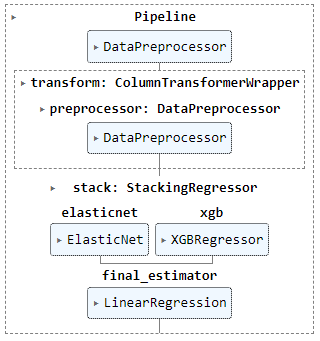

In [17]:
# make prediction on a small part of test data
# as the y was log-transformed during fitting/training the model, we need to exp-transform the predictions
predictions = np.exp(pipeline.predict(X_test[0:5]))
predictions

array([123056.68816801, 161556.64668924, 182618.22643544, 195772.21916238,
       186202.04479163])

In [18]:
# make prediction on full test data
# as the y was log-transformed during fitting/training the model, we need to exp-transform the predictions
predictions = np.exp(pipeline.predict(X_test))
output = pd.DataFrame({'Id': test.index, 'SalePrice': predictions})
output.to_csv('y_pred.csv', index=False)
print(output.head())

     Id      SalePrice
0  1461  122547.494684
1  1462  160890.136000
2  1463  183593.913330
3  1464  196901.009207
4  1465  186396.020409


In [19]:
time_end = time.time()
print("Notebook run time: {:.0f} seconds".format(time_end - time_start))

Notebook run time: 82 seconds
